In [ ]:
#pip install catboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
#from catboost import Pool

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### Data Exploration

In [2]:
weekly_data= pd.read_csv(r"C:\Users\91758\Downloads\Food Demand Forecasting\train_GzS76OK\train.csv")

In [3]:
meal= pd.read_csv(r"C:\Users\91758\Downloads\Food Demand Forecasting\train_GzS76OK\meal_info.csv")

In [4]:
fulfilment= pd.read_csv(r"C:\Users\91758\Downloads\Food Demand Forecasting\train_GzS76OK\fulfilment_center_info.csv")

In [5]:
weekly_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [6]:
weekly_data.shape

(456548, 9)

In [7]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [8]:
meal.shape

(51, 3)

In [9]:
fulfilment.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [10]:
fulfilment.shape

(77, 5)

In [11]:
df= pd.merge(weekly_data,fulfilment, on='center_id')

In [12]:
df= pd.merge(df,meal, on='meal_id')

In [13]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [14]:
df.shape

(456548, 15)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
category                 456548 non-null object
cuisine                  456548 non-null object
dtypes: float64(3), int64(9), object(3)
memory usage: 55.7+ MB


In [16]:
df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


In [17]:
df['week'].nunique()

145

In [18]:
l=['center_id','meal_id','city_code','region_code','center_type','op_area','category','cuisine']
for i in l:
    print(i)
    print(df[i].value_counts())
    print('----------------------------------------------------------')

center_id
13     7046
10     7015
52     6993
43     6970
67     6915
137    6894
174    6891
51     6880
27     6853
108    6843
11     6801
132    6788
36     6776
59     6716
89     6706
153    6696
104    6687
20     6671
30     6666
53     6538
23     6434
80     6396
126    6389
17     6333
109    6296
99     6293
72     6252
101    6172
146    6164
76     6099
       ... 
42     5846
93     5763
145    5732
157    5721
106    5715
110    5712
88     5608
161    5591
64     5547
73     5536
186    5528
29     5438
113    5379
39     5377
58     5296
177    5296
94     5292
74     5264
77     5250
24     5233
55     5146
26     5085
149    5021
102    4939
92     4712
139    4627
57     4501
162    4366
41     4083
91     3432
Name: center_id, Length: 77, dtype: int64
----------------------------------------------------------
meal_id
2290    11138
1062    11137
1727    11136
1109    11134
1754    11132
2707    11123
1778    11121
1993    11116
1962    11114
1971    11102
1885    1

#### Preprocessing

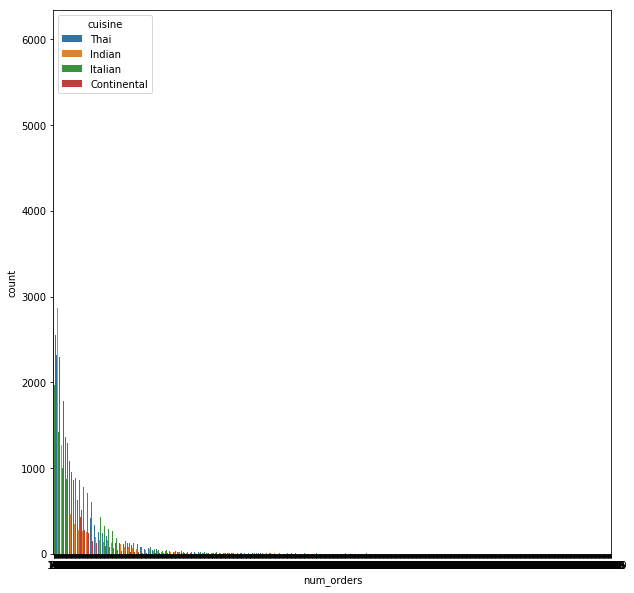

In [19]:
plt.figure(figsize=(10,10))
sns.countplot(df['num_orders'], hue=df['cuisine'])

In [20]:
correlation= df.corr()
correlation

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
id,1.000000,0.002225,0.002641,0.000488,0.001941,0.002909,0.002001,0.003111,0.000702,-0.000387,-0.000648,-0.000090
week,0.002225,1.000000,-0.003450,0.019814,0.026581,0.028614,-0.000841,-0.008263,-0.017210,0.000405,0.004600,0.001550
center_id,0.002641,-0.003450,1.000000,0.009893,0.001348,0.000604,0.013658,-0.005043,-0.053035,0.061078,-0.003426,-0.111869
meal_id,0.000488,0.019814,0.009893,1.000000,0.010748,0.002605,0.013402,0.016354,0.010597,-0.003198,-0.001662,-0.001546
checkout_price,0.001941,0.026581,0.001348,0.010748,1.000000,0.953389,0.004818,-0.057184,-0.282108,-0.004805,-0.003648,0.021569
base_price,0.002909,0.028614,0.000604,0.002605,0.953389,1.000000,0.171173,0.057156,-0.222306,-0.002054,-0.001934,0.018031
emailer_for_promotion,0.002001,-0.000841,0.013658,0.013402,0.004818,0.171173,1.000000,0.390534,0.277147,-0.005234,-0.007462,-0.019462
homepage_featured,0.003111,-0.008263,-0.005043,0.016354,-0.057184,0.057156,0.390534,1.000000,0.294490,0.008640,0.003605,0.041498
num_orders,0.000702,-0.017210,-0.053035,0.010597,-0.282108,-0.222306,0.277147,0.294490,1.000000,0.041596,0.029744,0.176976
city_code,-0.000387,0.000405,0.061078,-0.003198,-0.004805,-0.002054,-0.005234,0.008640,0.041596,1.000000,0.042686,0.131476


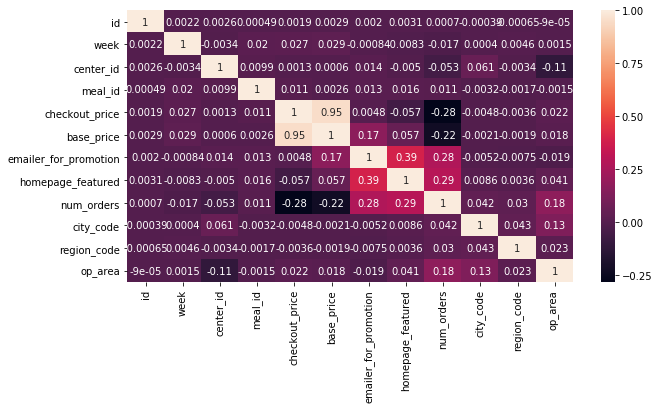

In [21]:
plt.figure(figsize=(10,5))
sns.heatmap(correlation, annot= True)

base_price and  checkout_price are highly correlated(0.95). So we can drop one column.(We are going to drop checkout_price)

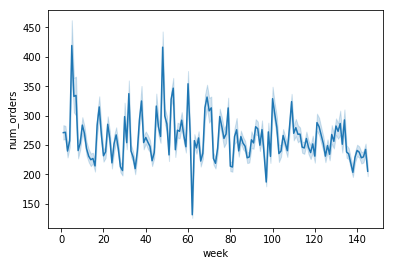

In [22]:
sns.lineplot(df['week'], df['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

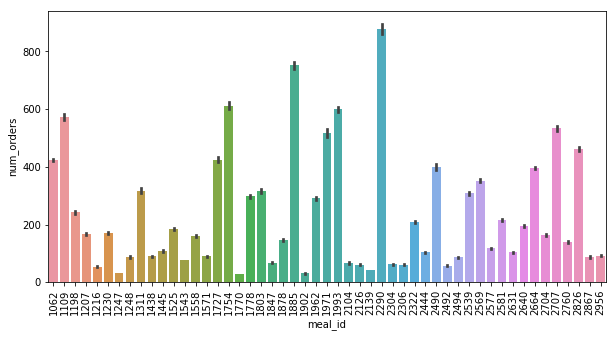

In [23]:
plt.figure(figsize= (10,5))
sns.barplot(df['meal_id'], df['num_orders'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text xticklabel objects>)

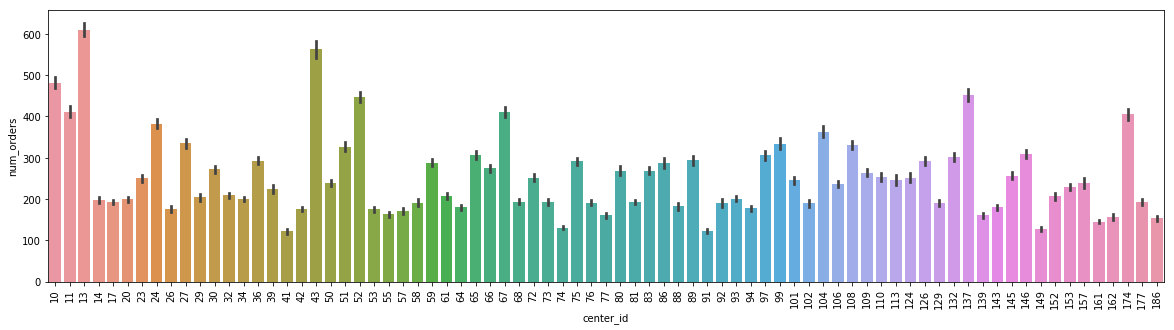

In [24]:
plt.figure(figsize= (20,5))
sns.barplot(df['center_id'], df['num_orders'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

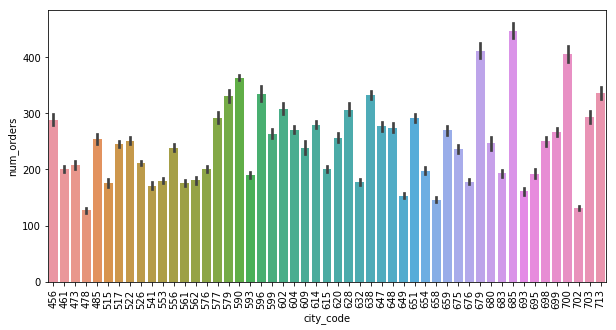

In [25]:
plt.figure(figsize= (10,5))
sns.barplot(df['city_code'], df['num_orders'])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

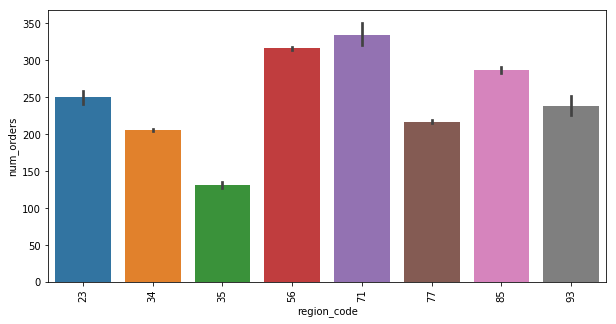

In [26]:
plt.figure(figsize= (10,5))
sns.barplot(df['region_code'], df['num_orders'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

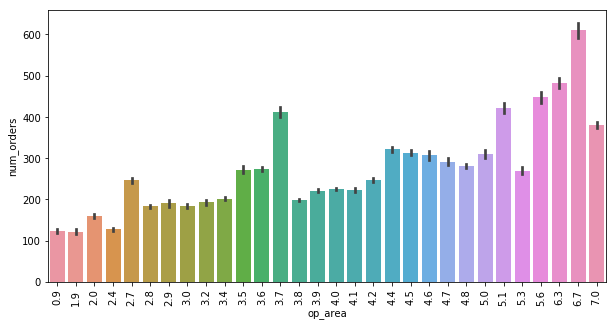

In [27]:
plt.figure(figsize= (10,5))
sns.barplot(df['op_area'], df['num_orders'])
plt.xticks(rotation=90)

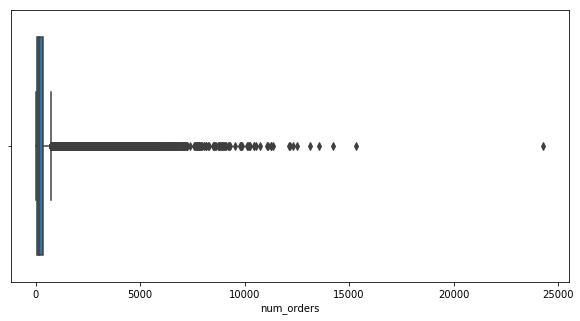

In [28]:
plt.figure(figsize= (10,5))
sns.boxplot(df['num_orders'])

In [29]:
#Remove outliers
o= df[df['num_orders']>15000].index
df= df.drop(o)

In [30]:
l=['center_type','op_area','cuisine','category']
le=LabelEncoder()
for i in l:
    df[i]= le.fit_transform(df[i])

In [31]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,2,2,0,3
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,2,2,0,3
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,2,2,0,3
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,2,2,0,3
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,2,2,0,3


In [32]:
x= df.drop(['id','num_orders','checkout_price'],axis=1)
y= df['num_orders']

In [33]:
y.isnull().sum()

0

In [34]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456546 entries, 0 to 456547
Data columns (total 12 columns):
week                     456546 non-null int64
center_id                456546 non-null int64
meal_id                  456546 non-null int64
base_price               456546 non-null float64
emailer_for_promotion    456546 non-null int64
homepage_featured        456546 non-null int64
city_code                456546 non-null int64
region_code              456546 non-null int64
center_type              456546 non-null int32
op_area                  456546 non-null int64
category                 456546 non-null int32
cuisine                  456546 non-null int32
dtypes: float64(1), int32(3), int64(8)
memory usage: 40.1 MB


In [35]:
x_train, x_valid, y_train, y_valid= train_test_split(x,y,test_size=0.2, random_state=23)

In [36]:
#Random Forest Regressor
model= RandomForestRegressor(n_estimators= 20, n_jobs=-1, random_state=35)
model.fit(x_train,y_train)
pred1= model.predict(x_valid)
print("RMSE:", np.sqrt(mean_squared_error(y_valid,pred1)))
print("RMSLE:", np.sqrt(mean_squared_log_error(y_valid,pred1))*100)

RMSE: 161.82954560751702
RMSLE: 50.88728269333873


In [37]:
#XGBoost Regressor
model1= XGBRegressor()
model1.fit(x_train,y_train)
pred2= model1.predict(x_valid)
print("RMSE:", np.sqrt(mean_squared_error(y_valid,pred2)))
print("RMSLE:", np.sqrt(mean_squared_log_error(y_valid,pred2))*100)

RMSE: 175.33153758642683


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

m= RandomForestRegressor(n_estimators= 10, n_jobs=-1, random_state=35)

fold = KFold(n_splits=5,shuffle=True,random_state=2019)

for train_index, test_index in fold.split(x,y):
    X_train, X_valid = x.iloc[train_index], x.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    m.fit(X_train,y_train)
    preds = m.predict(X_valid)
    print("err: ",np.sqrt(mean_squared_error(y_valid,preds)))

In [38]:
weekly_data_test= pd.read_csv(r"C:\Users\91758\Downloads\Food Demand Forecasting\test_QoiMO9B.csv")

In [39]:
df_test= pd.merge(weekly_data_test,fulfilment, on='center_id')
df_test= pd.merge(df_test,meal, on='meal_id')

In [40]:
df_test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai


In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 14 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
city_code                32573 non-null int64
region_code              32573 non-null int64
center_type              32573 non-null object
op_area                  32573 non-null float64
category                 32573 non-null object
cuisine                  32573 non-null object
dtypes: float64(3), int64(8), object(3)
memory usage: 3.7+ MB


In [42]:
for i in l:
    df_test[i]= le.fit_transform(df_test[i])

In [43]:
x_test= df_test.drop(['id','checkout_price'],axis=1)

In [44]:
prediction= model.predict(x_test)

In [45]:
pre= pd.Series(prediction)

In [46]:
dataframe= pd.concat([df_test['id'], pre], axis=1)
dataframe.columns=['id','num_orders']

In [47]:
dataframe.head()

,id,num_orders
0,1028232,82.35
1,1262649,82.35
2,1453211,82.35
3,1262599,86.40
4,1495848,82.35


In [48]:
dataframe.to_csv("C:/Users/91758/Downloads/Food Demand Forecasting/solution.csv", index= False)